## **<span style="color:purple">합성곱 신경망의 구성 요소</span>** ##
---
- 7장의 밀집층에는 뉴런마다 입력 개수만큼의 가중치가 있음
  - 가중치와 절편을 랜덤하게 초기화한 다음, 에포크를 반복하면서 경사 하강법 알고리즘을 사용하여 손실이 낮아지도록 최적의 가중치와 절편을 찾아감
  
- 합성곱은 입력 데이터 전체에 가중치를 적용하는 것이 아니라, 일부에 가중치를 곱함
- 합성곱 신경망(CNN)에서는 뉴런을 필터라고 함
- 커널은 입력에 곱하는 가중치임
- 특성 맵: 합성곱 계산을 통해 얻은 출력
- 이미지 처리 분야에서 뛰어난 성능을 발휘함
- 합성곱 층을 1개 이상 사용한 인공 신경망을 합성곱 신경망이라고 함

#### **케라스 합성곱 층**
- 패딩: 입력 배열의 주위를 가상의 원소로 채우는 것 -> 출력의 크기를 설정하기 위해, 원소들이 계산에 포함되는 수를 조정
- 세임 패딩: 입력과 특성 맵의 크기를 동일하게 만들기 위해 입력 주위에 0으로 패딩하는 것
- 밸리드 패딩: 패딩 없이 순수한 입력 배열에서만 합성곱을 하여 특성 맵을 만드는 경우, 기본값임("valid")
- 스트라이드: 이동의 크기, 기본값은 1임(한 칸씩 이동)
- 풀링: 합성곱 층에서 만든 특성 맵의 크기를 줄이지만, 개수는 유지함, 가중치가 없음, 풀링 크기와 스트라이드가 같음
   - 최대 풀링: 도장을 찍은 영역에서 가장 큰 값을 고름 -> MaxPooling2D
   - 평균 풀링: 도장을 찍은 영역에서 평균값을 계산 -> AveragePooling2D

In [1]:
from tensorflow import keras

# 필터의 개수, 커널의 크기, 활성화 함수
keras.layers.Conv2D(10,kernel_size=(3,3),activation="relu",padding="same", strides=1) 

# 풀링의 크기(2)-> (2,2), 패딩 매개변수는 있지만, 패딩을 하진 않음-> 매개변수를 바꾸는 일이 거의 없음
keras.layers.MaxPooling2D(2,strides=2,padding="valid")

#### **합성곱 신경망의 전체 구조**
입력 -> 합성곱 층(세임 패딩) -> 풀링층 ->밀집층 -> 예측

#### **컬러 이미지를 사용한 합성곱**
- 컬러 이미지는 RGB 채널로 구성되어 있기 때문에 3차원 배열임
- 커널 크기도 3차원이어야 함, 깊이는 입력의 깊이만큼 설정함
- 케라스는 3차원 입력을 기대함 -> 2차원 배열일 경우 깊이가 1인 3차원 배열로 변환함
- 필터의 개수가 특성 맵의 깊이를 결정함
- 필터가 늘어날 수록 이미지에 있는 구체적인 특징을 찾는다고 생각하면 됨. (ex.기본적인 특징 -> 구체적인 특징)

## **<span style="color:purple">합성곱 신경망을 사용한 이미지 분류</span>** ##
---
#### **패션 MNIST 데이터 불러오기**

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input,train_target),(test_input,test_target)=keras.datasets.fashion_mnist.load_data()
train_scaled=train_input.reshape(-1,28,28,1)/255.0 # 이미지마다 1의 깊이를 만듬
train_scaled,val_scaled,train_target,val_target=train_test_split(train_scaled,
                                                                train_target,test_size=0.2,
                                                                random_state=42)

#### **합성곱 신경망 만들기**

In [3]:
model=keras.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=3,activation="relu",padding="same",input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2)) # (14,14,32) 가 됨
model.add(keras.layers.Conv2D(64, kernel_size=3,activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(2)) # (7,7,64) 가 됨
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

In [10]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### **모델 컴파일과 훈련**

In [12]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")
checkpoint_cb=keras.callbacks.ModelCheckpoint("best-cnn-model.h5",save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
history=model.fit(train_scaled,train_target,epochs=20,validation_data=(val_scaled,val_target),
                 callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 71s 46ms/step - loss: 0.5255 - accuracy: 0.8115 - val_loss: 0.3429 - val_accuracy: 0.8749
Epoch 2/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.3423 - accuracy: 0.8780 - val_loss: 0.2797 - val_accuracy: 0.8955
Epoch 3/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.2952 - accuracy: 0.8929 - val_loss: 0.2579 - val_accuracy: 0.9006
Epoch 4/20
1500/1500 [==============================] - 78s 52ms/step - loss: 0.2610 - accuracy: 0.9043 - val_loss: 0.2464 - val_accuracy: 0.9083
Epoch 5/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.2355 - accuracy: 0.9131 - val_loss: 0.2361 - val_accuracy: 0.9131
Epoch 6/20
1500/1500 [==============================] - 77s 52ms/step - loss: 0.2195 - accuracy: 0.9186 - val_loss: 0.2174 - val_accuracy: 0.9188
Epoch 7/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.1989 - accuracy: 0.9275 - val_loss: 0.2234 -

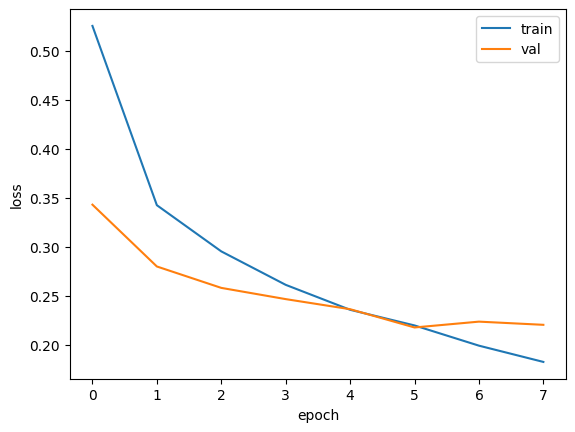

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

In [14]:
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 6s 14ms/step - loss: 0.2174 - accuracy: 0.9188


[0.2174406498670578, 0.918833315372467]

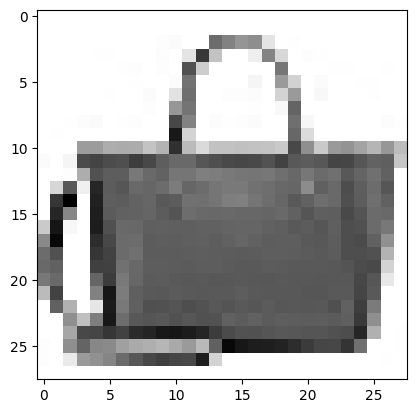

In [15]:
plt.imshow(val_scaled[0].reshape(28,28),cmap="gray_r")
plt.show()

In [16]:
preds=model.predict(val_scaled[0:1]) # 입력의 첫번 째 차원이 배치 차원일 것으로 기대하기 떄문에, (1,28,28,1)의 크기를 전달
print(preds)

1/1 [==============================] - 0s 386ms/step
[[1.68868168e-16 8.19045879e-23 8.54850168e-22 2.44481502e-17
  2.41841245e-20 1.17347365e-17 3.08440968e-18 4.76336323e-17
  1.00000000e+00 1.53989253e-16]]


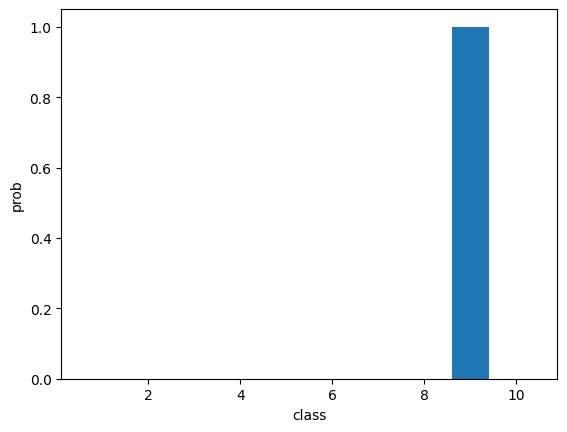

In [17]:
plt.bar(range(1,11),preds[0])
plt.xlabel("class")
plt.ylabel("prob")
plt.show()

In [18]:
classes=["티셔츠","바지","스웨터","드레스","코트","샌달","셔츠","스니커즈","가방","앵클 부츠"]

In [20]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [22]:
test_scaled=test_input.reshape(-1,28,28,1)/255.0
model.evaluate(test_scaled,test_target)

313/313 [==============================] - 6s 16ms/step - loss: 0.2439 - accuracy: 0.9147


[0.2439393848180771, 0.9146999716758728]

## **<span style="color:purple">합성곱 신경망의 시각화</span>** ##
---
#### **가중치 시각화**

In [24]:
from tensorflow import keras
model=keras.models.load_model("best-cnn-model.h5")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc4 in position 17: invalid continuation byte

In [28]:
'''
import h5py
from tensorflow import keras

model_path = "best-cnn-model.h5"

# HDF5 파일 형식으로 저장된 모델을 로드합니다.
with h5py.File(model_path, 'r') as f:
    model = keras.models.load_model(f)
'''

'\nimport h5py\nfrom tensorflow import keras\n\nmodel_path = "best-cnn-model.h5"\n\n# HDF5 파일 형식으로 저장된 모델을 로드합니다.\nwith h5py.File(model_path, \'r\') as f:\n    model = keras.models.load_model(f)\n'

In [25]:
model.layers

In [31]:
conv=model.layers[0]
print(conv.weights[0].shape,conv.weights[1].shape) # 가중치, 절편

(3, 3, 1, 32) (32,)


In [32]:
conv_weights=conv.weights[0].numpy()
print(conv_weights.mean(),conv_weights.std())

-0.025146544 0.22683468


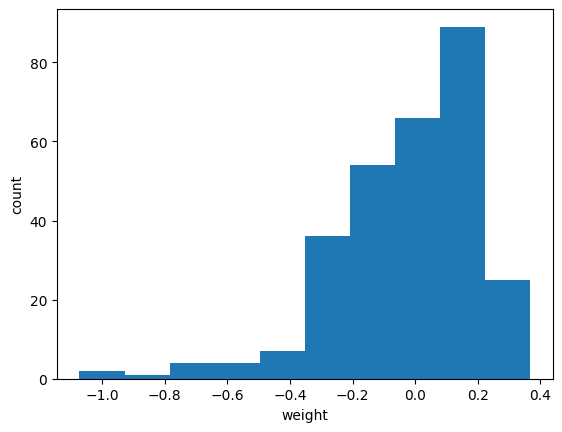

In [33]:
plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel("count")
plt.show()

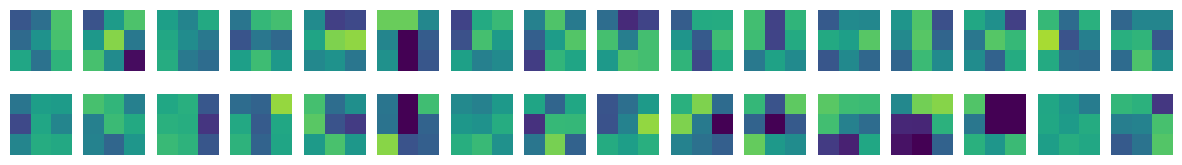

In [35]:
fig,axs=plt.subplots(2,16,figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(conv_weights[:,:,0,i*16+j],vmin=-0.5,vmax=0.5)
        axs[i,j].axis("off")
plt.show()

In [37]:
no_training_model=keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32,kernel_size=3,activation="relu",padding="same",input_shape=(28,28,1)))

In [38]:
no_training_conv=no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [42]:
no_training_weights=no_training_conv.weights[0].numpy()
print(no_training_weights.mean(),no_training_weights.std())

-0.0042016828 0.08256909


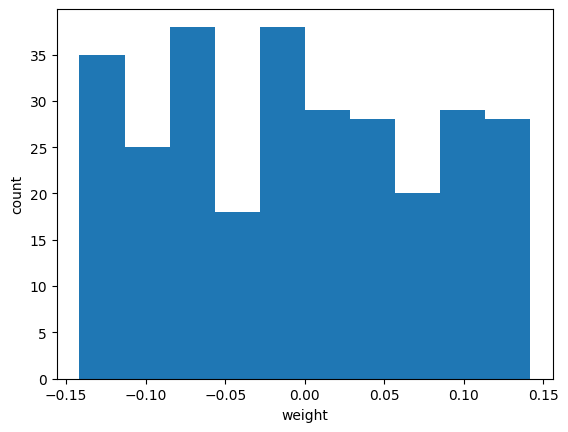

In [43]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel("count")
plt.show()

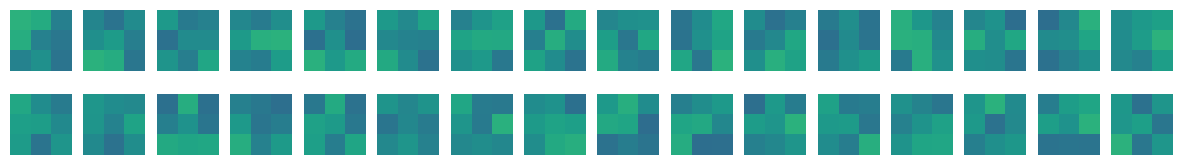

In [44]:
fig,axs=plt.subplots(2,16,figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(no_training_weights[:,:,0,i*16+j],vmin=-0.5,vmax=0.5)
        axs[i,j].axis("off")
plt.show()

#### **함수형 API**
- 딥러닝에서 좀 더 복잡한 모델을 만들 때는 Sequential 클래스를 사용하기 어려움

In [47]:
dense1=keras.layers.Dense(100,activation="sigmoid")
dense2=keras.layers.Dense(10,activation="softmax")

inputs=keras.Input(shape=(784,))
hidden=dense1(inputs)
outputs=dense2(hidden)

model=keras.Model(inputs,outputs)

print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


#### **특성 맵 시각화**
- 이해하기 힘듬...이 부분은 추후 다시 공부할 것